# Process recount2 data
This notebook does the following:

1. Selects template experiment
2. Downloads subset of recount2 data, including the template experiment (50 random experiments + 1 template experiment)
3. Train VAE on subset of recount2 data

In [1]:
%load_ext autoreload
%load_ext rpy2.ipython
%autoreload 2

import os
import sys
import pandas as pd
import numpy as np
import random
import rpy2
import seaborn as sns
from sklearn import preprocessing
import pickle

sys.path.append("../")
from ponyo import generate_template_data, utils, pipeline
from functions import process, calc

from numpy.random import seed
randomState = 123
seed(randomState)

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
Using TensorFlow backend.


In [2]:
# Read in config variables
base_dir = os.path.abspath(os.path.join(os.getcwd(),"../"))

config_file = os.path.abspath(os.path.join(base_dir,
                                           "config_human.tsv"))
params = utils.read_config(config_file)

### Select template experiment

We manually selected bioproject [SRP012656](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE37764), which contains primary non-small cell lung adenocarcinoma tumors and adjacent normal tissues of 6 never-smoker Korean female patients with 2 replicates each.

In [3]:
# Load params
local_dir = params["local_dir"]
dataset_name = params['dataset_name']
NN_architecture = params['NN_architecture']
project_id = params['project_id']

### Download subset of recount2 to use as a compendium
The compendium will be composed of random experiments + the selected template experiment

In [4]:
%%R
# Select 59
# Select a
# Run one time
#if (!requireNamespace("BiocManager", quietly = TRUE))
#    install.packages("BiocManager")
#BiocManager::install("derfinder")
#BiocManager::install("recount")

NULL


In [5]:
%%R
library('recount')

In [6]:
#%%R -i project_id -i local_dir

#source('../functions/download_recount2_data.R')

#get_recount2_compendium(project_id, local_dir)

### Download expression data for selected project id

In [7]:
%%R -i project_id -i local_dir

source('../functions/download_recount2_data.R')

get_recount2_template_experiment(project_id, local_dir)

Loading objects:
  rse_gene


### Subset genes
For our downstream analysis we will be comparing our set of differentially expression genes against the set found in [Crow et. al. publication](https://www.pnas.org/content/pnas/116/13/6491.full.pdf), therefore we will limit our genes to include only those genes shared between our starting set of genes and those in publication. 

In [8]:
# Get generic genes identified by Crow et. al.
DE_prior_file = "https://raw.githubusercontent.com/maggiecrow/DEprior/master/DE_Prior.txt"

DE_prior = pd.read_csv(DE_prior_file,
                       header=0,
                       sep="\t")

DE_prior.head()

,Gene_Order,Gene_EntrezID,N_HitLists,DE_Prior_Rank,Gene_Name
0,1,7503,79,1.000000,XIST
1,2,8653,64,0.999948,DDX3Y
2,3,9086,62,0.999870,EIF1AY
3,4,8284,52,0.999870,KDM5D
4,5,8287,46,0.999791,USP9Y


In [9]:
# Get list of published generic genes
published_generic_genes = list(DE_prior['Gene_Name'])

In [10]:
# Get list of our genes
# Load real template experiment
template_data_file = params['template_data_file']

# Read template data
template_data = pd.read_csv(
    template_data_file,
    header=0,
    sep='\t',
    index_col=0)

our_gene_ids = list(template_data.columns)

In [11]:
# File mapping ensembl ids to hgnc symbols
gene_id_file = os.path.join(
    local_dir,
    "ensembl_hgnc_mapping.tsv")

In [12]:
%%R
suppressWarnings(library("biomaRt"))

In [13]:
%%R -i template_data_file -i gene_id_file

# Get mapping between ensembl gene ids (ours) to HGNC gene symbols (published)

source('../functions/process_names.R')

if (file.exists(gene_id_file) == FALSE){
    gene_id_mapping <- get_ensembl_symbol_mapping(template_data_file, gene_id_file)
}

In [14]:
# Read gene id mapping
gene_id_mapping = pd.read_csv(
        gene_id_file,
        header=0,
        sep='\t',
        index_col=0)

print(gene_id_mapping.shape)
gene_id_mapping.head()

(57210, 2)


,ensembl_gene_id,hgnc_symbol
1,ENSG00000002330,BAD
2,ENSG00000003137,CYP26B1
3,ENSG00000003249,DBNDD1
4,ENSG00000004799,PDK4
5,ENSG00000006062,MAP3K14


In [15]:
# Get mapping between ensembl ids with and without version numbers
# Expressiond data uses ensembl gene ids with version number 
ensembl_gene_ids = pd.DataFrame(data={'ensembl_version': our_gene_ids,
                                      'ensembl_parsed': [gene_id.split('.')[0] for gene_id in our_gene_ids]})

print(ensembl_gene_ids.shape)
ensembl_gene_ids.head()

(58037, 2)


,ensembl_version,ensembl_parsed
0,ENSG00000000003.14,ENSG00000000003
1,ENSG00000000005.5,ENSG00000000005
2,ENSG00000000419.12,ENSG00000000419
3,ENSG00000000457.13,ENSG00000000457
4,ENSG00000000460.16,ENSG00000000460


In [16]:
# Map ensembl ids with version number to gene_id_mapping_df
gene_id_mapping = pd.merge(gene_id_mapping, 
                           ensembl_gene_ids, 
                           left_on='ensembl_gene_id',
                           right_on='ensembl_parsed', 
                           how='outer')

print(gene_id_mapping.shape)
gene_id_mapping.set_index('ensembl_version', inplace=True)
gene_id_mapping.head()

(58129, 4)


,ensembl_gene_id,hgnc_symbol,ensembl_parsed
ensembl_version,,,
ENSG00000002330.13,ENSG00000002330,BAD,ENSG00000002330
ENSG00000003137.8,ENSG00000003137,CYP26B1,ENSG00000003137
ENSG00000003249.13,ENSG00000003249,DBNDD1,ENSG00000003249
ENSG00000004799.7,ENSG00000004799,PDK4,ENSG00000004799
ENSG00000006062.13,ENSG00000006062,MAP3K14,ENSG00000006062


Since this experiment contains both RNA-seq and smRNA-seq samples which are in different ranges so we will drop smRNA samples so that samples are within the same range. The analysis identifying these two subsets of samples can be found in this [notebook](0_explore_input_data.ipynb)

In [17]:
# Replace ensembl ids with gene symbols
template_data = process.replace_ensembl_ids(template_data,
                                            gene_id_mapping)

In [18]:
template_data.head()

,TSPAN6,TNMD,DPM1,SCYL3,C1orf112,FGR,CFH,FUCA2,GCLC,NFYA,...,MIR6830,MIR548AH,MYOCOS,MIR522,MIR6715B,MIR3116-2,MIR3202-2,HSFX3,VINAC1P,MIR4481
SRR493937,3.800154,0.018190,9.128459,1.585803,0.713952,84.990542,19.943002,12.065586,2.498822,7.713002,...,0.000000,0.0,0.135649,0.0,0.0,0.00000,0.000000,0.588513,0.0,0.000000
SRR493938,3.798473,0.000000,9.157669,1.456017,0.738967,85.788323,19.621252,11.738855,2.435308,7.125808,...,0.005417,0.0,0.127873,0.0,0.0,0.00000,0.000000,0.452511,0.0,0.000000
SRR493939,20.222134,0.000000,15.522072,3.944919,2.512265,8.072948,47.246078,18.866957,2.443230,12.143670,...,0.000000,0.0,0.011112,0.0,0.0,0.00000,0.000000,0.446833,0.0,0.000000
SRR493940,19.988329,0.000000,17.140304,3.977217,2.378849,7.599225,46.594458,18.921190,2.448276,12.048960,...,0.147412,0.0,0.037886,0.0,0.0,0.07756,0.000000,0.462295,0.0,0.168159
SRR493941,3.239231,0.019398,9.069316,2.181582,1.008155,17.675885,19.371137,11.759756,1.970725,6.740705,...,0.002860,0.0,0.156220,0.0,0.0,0.00000,0.070955,0.739403,0.0,0.000000


In [19]:
# Get intersection of gene lists
our_gene_ids_hgnc = template_data.columns
shared_genes_hgnc = list(set(our_gene_ids_hgnc).intersection(published_generic_genes))
print(len(shared_genes_hgnc))

17785


In [20]:
# Save shared genes
shared_genes_file = os.path.join(
    local_dir,
    "shared_gene_ids.pickle")

outfile = open(shared_genes_file,'wb')
pickle.dump(shared_genes_hgnc,outfile)
outfile.close()

In [21]:
# Drop smRNA samples so that samples are within the same range
smRNA_samples = ["SRR493961",
                 "SRR493962",
                 "SRR493963",
                 "SRR493964",
                 "SRR493965",
                 "SRR493966",
                 "SRR493967",
                 "SRR493968",
                 "SRR493969",
                 "SRR493970",
                 "SRR493971",
                 "SRR493972"]

In [22]:
# Drop samples
template_data = template_data.drop(smRNA_samples)

In [23]:
# Drop genes
template_data = template_data[shared_genes_hgnc]

print(template_data.shape)
template_data.head()

(24, 17788)


,GIN1,ATP7B,STX2,CALML4,IL33,NDUFA2,NIPA2,CC2D1B,KRT36,SLC11A2,...,FHL1,FAM217B,SLC35A3,FOXN3-AS2,ADA,MAP2K3,NALT1,TAGLN2,BNIPL,LINC00347
SRR493937,0.417450,0.759499,7.613760,2.323535,9.642060,14.113645,9.881540,8.198958,0.062911,7.248503,...,37.449507,1.091419,1.293227,0.056591,5.864003,37.955511,0.237908,203.274943,1.633338,0.0
SRR493938,0.347168,0.716985,7.538773,2.336309,9.245066,14.110478,9.881625,7.916165,0.134185,7.129752,...,36.873251,1.356671,1.286098,0.000000,6.150213,38.353524,0.215899,203.325487,1.741487,0.0
SRR493939,1.138175,1.018688,4.737578,4.695277,5.122216,22.931247,16.740047,6.950964,0.038414,9.808788,...,12.443081,3.146085,2.794109,0.056769,1.991244,18.459524,0.563715,271.517372,10.779878,0.0
SRR493940,1.122192,0.978475,5.165053,4.244555,5.454740,22.960795,16.548409,7.097180,0.034181,9.039494,...,12.429557,3.093992,2.747011,0.113382,1.954822,19.248248,0.725859,275.122932,10.762544,0.0
SRR493941,0.918446,1.189247,8.903652,2.575475,22.055795,11.888733,8.874095,7.536602,0.000000,6.911916,...,88.078674,2.411141,1.832149,0.000000,1.686847,14.324926,0.799124,243.736213,5.665132,0.0


In [24]:
print(len(template_data.columns) - len(shared_genes_hgnc))

3


*Note:* There is a difference in the number of `shared_genes_hgnc` and genes in the template experiment because 3 genes have 2 different ensembl gene ids have map to the same hgnc symbol (one forward, one reverse)

In [25]:
# Save 
template_data.to_csv(template_data_file, float_format='%.5f', sep='\t')

### Normalize compendium 

In [26]:
# Load real gene expression data
original_compendium_file = params['compendium_data_file']

In [27]:
# Read data
original_compendium = pd.read_table(
    original_compendium_file,
    header=0,
    sep='\t',
    index_col=0)

print(original_compendium.shape)
original_compendium.head()

(1552, 17785)


,NDUFV3,BCL7B,ROCK1,CEP63,DOCK5,PCCB,TFAP2E,C2orf68,SMUG1,LINC01732,...,AP3B2,SMC5-AS1,RLN3,ABCA17P,TCF7L2,SERGEF,HEG1,SOAT2,ZNF580,GAB1
SRR1604987,5.136,11.853,4.617,2.393,2.605,8.457,0.752,6.263,5.216,0.000,...,0.016,0.339,0.000,0.048,5.441,2.726,0.368,0.000,5.750,1.914
SRR1604988,5.353,12.644,4.572,2.167,2.496,8.510,0.644,6.235,5.367,0.024,...,0.012,0.356,0.000,0.056,5.082,2.510,0.423,0.000,5.889,1.966
SRR1604989,4.626,11.857,6.538,2.181,5.051,9.494,0.755,8.944,4.585,0.000,...,0.011,0.626,0.003,0.041,6.170,3.030,0.990,0.000,5.634,2.003
SRR1604990,4.136,12.147,6.851,2.292,4.973,9.228,0.683,8.495,4.465,0.000,...,0.020,0.532,0.023,0.024,5.859,2.854,0.919,0.000,5.560,2.048
SRR1604991,5.182,10.447,7.212,1.411,7.680,7.424,0.226,4.350,3.773,0.000,...,0.016,0.456,0.000,0.062,2.426,3.039,12.955,0.008,5.845,1.751


In [28]:
# Replace ensembl ids with gene symbols
#original_compendium = process.replace_ensembl_ids(original_compendium,
#                                                gene_id_mapping)

In [29]:
# Drop genes
original_compendium = original_compendium[shared_genes_hgnc]

original_compendium.head()

,GIN1,ATP7B,STX2,CALML4,IL33,NDUFA2,NIPA2,CC2D1B,KRT36,SLC11A2,...,FHL1,FAM217B,SLC35A3,FOXN3-AS2,ADA,MAP2K3,NALT1,TAGLN2,BNIPL,LINC00347
SRR1604987,2.390,0.718,1.672,1.643,0.007,24.263,10.499,9.866,0.001,10.171,...,0.774,4.924,2.727,0.000,6.939,32.849,0.155,237.958,0.070,0.000
SRR1604988,2.462,0.711,1.455,1.586,0.037,24.275,11.261,9.867,0.024,10.181,...,0.702,4.955,2.866,0.013,6.641,33.477,0.209,238.721,0.081,0.000
SRR1604989,1.603,0.814,2.398,2.534,0.010,14.434,15.402,7.834,0.001,8.509,...,0.689,4.520,4.233,0.000,7.546,28.347,0.123,149.598,0.144,0.000
SRR1604990,1.872,0.748,2.193,2.294,0.020,14.673,14.667,7.892,0.003,8.536,...,0.802,4.469,4.414,0.000,7.558,27.931,0.193,152.254,0.183,0.000
SRR1604991,0.786,1.362,6.530,1.390,0.012,18.238,17.125,10.627,0.001,3.683,...,7.346,5.528,2.535,0.000,9.323,32.487,0.311,241.787,0.105,0.004


In [30]:
# 0-1 normalize per gene
scaler = preprocessing.MinMaxScaler()
original_data_scaled = scaler.fit_transform(original_compendium)
original_data_scaled_df = pd.DataFrame(original_data_scaled,
                                columns=original_compendium.columns,
                                index=original_compendium.index)

print(original_data_scaled_df.shape)
original_data_scaled_df.head()

(1552, 17785)


,GIN1,ATP7B,STX2,CALML4,IL33,NDUFA2,NIPA2,CC2D1B,KRT36,SLC11A2,...,FHL1,FAM217B,SLC35A3,FOXN3-AS2,ADA,MAP2K3,NALT1,TAGLN2,BNIPL,LINC00347
SRR1604987,0.305080,0.041568,0.054991,0.037912,0.000060,0.017069,0.231072,0.360428,0.000048,0.520442,...,0.003385,0.160757,0.206403,0.000000,0.143451,0.365042,0.001353,0.057325,0.001368,0.000000
SRR1604988,0.314271,0.041163,0.047854,0.036597,0.000317,0.017078,0.247843,0.360465,0.001147,0.520954,...,0.003070,0.161770,0.216924,0.000017,0.137290,0.372020,0.001825,0.057509,0.001583,0.000000
SRR1604989,0.204621,0.047126,0.078869,0.058472,0.000086,0.010154,0.338982,0.286194,0.000048,0.435399,...,0.003013,0.147568,0.320391,0.000000,0.155999,0.315012,0.001074,0.036039,0.002814,0.000000
SRR1604990,0.238958,0.043305,0.072126,0.052934,0.000171,0.010323,0.322806,0.288313,0.000143,0.436780,...,0.003507,0.145903,0.334090,0.000000,0.156247,0.310389,0.001685,0.036679,0.003577,0.000000
SRR1604991,0.100332,0.078851,0.214767,0.032074,0.000103,0.012831,0.376904,0.388229,0.000048,0.188456,...,0.032124,0.180477,0.191871,0.000000,0.192735,0.361019,0.002715,0.058248,0.002052,0.001165


In [31]:
# Save data
normalized_data_file = params['normalized_compendium_data_file']

original_data_scaled_df.to_csv(
    normalized_data_file, float_format='%.3f', sep='\t')

original_compendium.to_csv(
    original_compendium_file, float_format='%.3f', sep='\t')

# Save scaler transform
scaler_file = params['scaler_transform_file']

outfile = open(scaler_file,'wb')
pickle.dump(scaler,outfile)
outfile.close()

### Train VAE 

In [32]:
# Setup directories
# Create VAE directories
output_dirs = [os.path.join(base_dir, dataset_name, "models"),
               os.path.join(base_dir, dataset_name, "logs")]

# Check if analysis output directory exist otherwise create
for each_dir in output_dirs:
    if os.path.exists(each_dir) == False:
        print('creating new directory: {}'.format(each_dir))
        os.makedirs(each_dir, exist_ok=True)

# Check if NN architecture directory exist otherwise create
for each_dir in output_dirs:
    new_dir = os.path.join(each_dir, NN_architecture)
    if os.path.exists(new_dir) == False:
        print('creating new directory: {}'.format(new_dir))
        os.makedirs(new_dir, exist_ok=True)

input dataset contains 1552 samples and 17785 genes
Instructions for updating:
Colocations handled automatically by placer.
tracking <tf.Variable 'Variable:0' shape=() dtype=float32> beta
Instructions for updating:
Use tf.cast instead.
Train on 1397 samples, validate on 155 samples
Epoch 1/40
1397/1397 [==============================] - 212s 152ms/step - loss: 3939.4017 - val_loss: 3470.9262
Epoch 2/40
1397/1397 [==============================] - 213s 152ms/step - loss: 3490.5036 - val_loss: 3332.3572
Epoch 3/40
1397/1397 [==============================] - 213s 152ms/step - loss: 3432.4731 - val_loss: 3301.5049
Epoch 4/40
1397/1397 [==============================] - 213s 153ms/step - loss: 3396.6803 - val_loss: 3286.1001
Epoch 5/40
1397/1397 [==============================] - 213s 153ms/step - loss: 3368.9985 - val_loss: 3243.4318
Epoch 6/40
1397/1397 [==============================] - 213s 153ms/step - loss: 3325.6143 - val_loss: 3226.9675
Epoch 7/40
1397/1397 [=======================

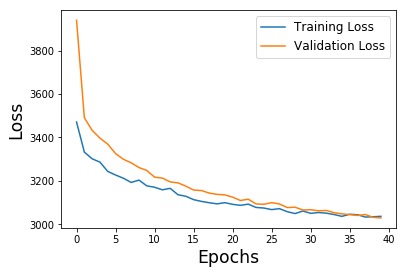

In [33]:
# Train VAE on new compendium data
pipeline.train_vae(config_file,
                   normalized_data_file)